# SVM Experiments

## Normalization

The issue of normalization is an important one. PCA and T-SNE analysis show that it is easier to observe emotion specific cluster when data is normalized in groups.
Without this type of normalization the data usually clusters around different actors.

For this reason we will try both with and without within group normalization.

Furthermore, experiments show that it doesn't give favorable results to apply the same normalization to the original data as the transfer data (furhat and metahuman).
Likely because there are significant differences in the feature distributions. We derive better results when we normalize the data conditions separately.


In [3]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn import metrics
import numpy as np
from sklearn.preprocessing import StandardScaler
import os

from nexa_py_sentimotion_mapper.sentimotion_mapper import Mapper

from constants import ROOT_DIR
from machine_learning.supervised_learning.evaluate.evaluate_scores import evaluate_scores
from machine_learning.supervised_learning.parameter_search.svm_ps import param_search
from machine_learning.supervised_learning.utils import save_parameters, load_parameters, get_features_openface
from machine_learning.supervised_learning.visualizations.misc_plots import plot_conf_mat
from machine_learning.utils import get_splits
from machine_learning.supervised_learning.svm_pipeline_big import n_fold_cross_validation, get_metrics

In [2]:
df_external = pd.read_csv(os.path.join(ROOT_DIR, "data/out/openface_data_external.csv"))
df_conditions = pd.read_csv(os.path.join(ROOT_DIR, "data/out/openface_data.csv"))

## Train external, test on transfer

The results show that training set validation has same results regardless of whether we use group normalization or not.

With an accuracy of about 0.5, and an AUC score of 0.85.

However, the performance degrades somewhat on the transfer data with this approach... Leading to much worse results on the original data, but basically equivalent results on the furhat and metahuman data.


### Without group normalization


printing accuracy measures
avg (train): 0.9770309298623531
std (train): 0.002058407193557615
avg (validation): 0.5119761508596783
std (validation): 0.017783144635398658

printing roc_auc_ovr measures
avg (train): 0.9992366743051427
std (train): 0.00011280313607255631
avg (validation): 0.8595418782686088
std (validation): 0.007701061874409122

printing f1_macro measures
avg (train): 0.9771784354841045
std (train): 0.0020253716179459455
avg (validation): 0.5094889871065331
std (validation): 0.01997439893225268
              precision    recall  f1-score   support

           1       0.53      0.53      0.53       376
           2       0.48      0.49      0.48       376
           3       0.46      0.47      0.47       379
           7       0.69      0.70      0.70       374
          26       0.44      0.55      0.49       374
          27       0.57      0.61      0.59       373
          29       0.54      0.44      0.49       379
          37       0.44      0.36      0.40       37

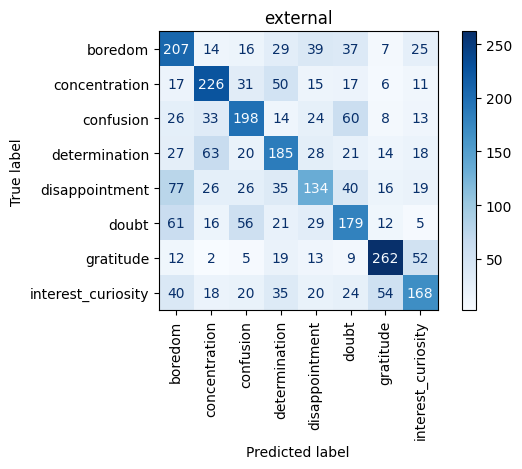

In [5]:
load_params = True

X_train = get_features_openface(df_external)
y_train = df_external["emotion_id"].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

if load_params:
    best_params = load_parameters()
else:
    gs = param_search(X_train, y_train, "accuracy")
    save_parameters(gs.best_params_)
    best_params = gs.best_params_

# Evaluate the model on the training data
y_pred = n_fold_cross_validation(best_params, X_train, y_train)
get_metrics(y_train, y_pred, condition="external")

In [ ]:
# train the model
clf = SVC(**best_params)
clf.fit(X_train, y_train)

clf_proba = SVC(**best_params, probability=True)
clf_proba.fit(X_train, y_train)


Evaluating for condition: furhat
(64, 186)
(64,)
              precision    recall  f1-score   support

           1       0.25      0.25      0.25         8
           2       0.27      0.38      0.32         8
           3       0.17      0.25      0.20         8
           7       0.50      0.25      0.33         8
          26       0.17      0.25      0.20         8
          27       0.17      0.12      0.14         8
          29       0.17      0.12      0.14         8
          37       0.00      0.00      0.00         8

    accuracy                           0.20        64
   macro avg       0.21      0.20      0.20        64
weighted avg       0.21      0.20      0.20        64

labels ['boredom' 'concentration' 'confusion' 'determination' 'disappointment'
 'doubt' 'gratitude' 'interest_curiosity']


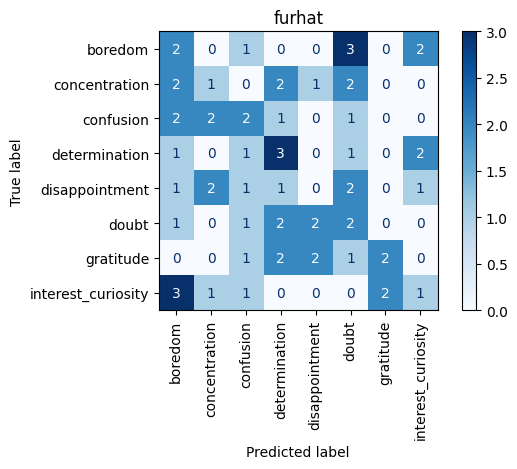


Evaluating for condition: metahuman
(64, 186)
(64,)
              precision    recall  f1-score   support

           1       0.17      0.38      0.23         8
           2       0.00      0.00      0.00         8
           3       0.15      0.25      0.19         8
           7       0.50      0.12      0.20         8
          26       0.38      0.38      0.38         8
          27       0.14      0.12      0.13         8
          29       0.00      0.00      0.00         8
          37       0.20      0.12      0.15         8

    accuracy                           0.17        64
   macro avg       0.19      0.17      0.16        64
weighted avg       0.19      0.17      0.16        64

labels ['boredom' 'concentration' 'confusion' 'determination' 'disappointment'
 'doubt' 'gratitude' 'interest_curiosity']


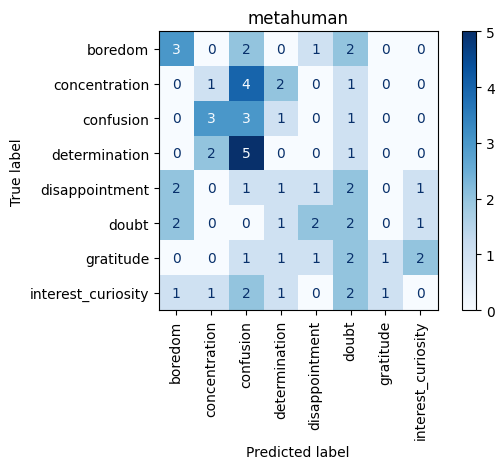


Evaluating for condition: original
(64, 186)
(64,)
              precision    recall  f1-score   support

           1       0.54      0.88      0.67         8
           2       0.56      0.62      0.59         8
           3       0.62      0.62      0.62         8
           7       0.83      0.62      0.71         8
          26       0.88      0.88      0.88         8
          27       0.75      0.75      0.75         8
          29       0.67      0.50      0.57         8
          37       0.50      0.38      0.43         8

    accuracy                           0.66        64
   macro avg       0.67      0.66      0.65        64
weighted avg       0.67      0.66      0.65        64

labels ['boredom' 'concentration' 'confusion' 'determination' 'disappointment'
 'doubt' 'gratitude' 'interest_curiosity']


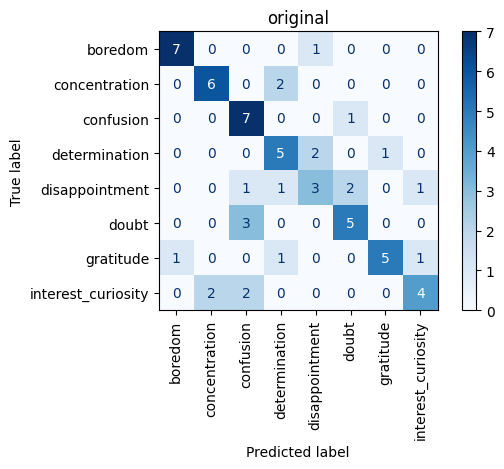

,condition,accuracy,f1_score,roc_auc_ovr
0,furhat,0.203125,0.198105,0.601004
1,metahuman,0.171875,0.160428,0.639788
2,original,0.656250,0.652398,0.907924


In [6]:
# Evaluate model on test data in different conditions
conditions = ["furhat", "metahuman", "original"]
all_scores = []
for c in conditions:
    print("\nEvaluating for condition:", c)

    df = df_conditions[df_conditions["condition"] == c]

    X_test = get_features_openface(df)

    y_test = df["emotion_id"].values

    print(X_test.shape)  # Number of rows and columns in the feature matrix
    print(y_test.shape)  # Number of rows in the target vector

    X_test = StandardScaler().fit_transform(X_test)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred, average="macro")
    roc_auc_ovr = metrics.roc_auc_score(y_test, clf_proba.predict_proba(X_test), multi_class="ovr")

    get_metrics(y_test, y_pred, condition=c)

    scores = {"condition": c, "accuracy": acc, "f1_score": f1_score, "roc_auc_ovr": roc_auc_ovr}

    all_scores.append(scores)

df_scores = pd.DataFrame(all_scores)
df_scores

### Within group normalization

In [9]:
from machine_learning.utils import functional_scale_by

load_params = False

X_train = get_features_openface(df_external)
y_train = df_external["emotion_id"].values

# Normalize the vectors
video_ids = df_external["video_id"].values
vec_normalized = functional_scale_by(X_train, video_ids, "standard")

if load_params:
    best_params = load_parameters()
else:
    gs = param_search(X_train, y_train, "accuracy")
    save_parameters(gs.best_params_)
    best_params = gs.best_params_

running param search
Fitting 5 folds for each of 168 candidates, totalling 840 fits
finished param search
{'C': 5, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}



printing accuracy measures
avg (train): 0.993425543361979
std (train): 0.0011282017081784045
avg (validation): 0.5026561286744314
std (validation): 0.016864728682344135

printing roc_auc_ovr measures
avg (train): 0.9999285704357185
std (train): 3.576728644824544e-05
avg (validation): 0.857009114486981
std (validation): 0.006028657771429834

printing f1_macro measures
avg (train): 0.9934407819087012
std (train): 0.001119025644652073
avg (validation): 0.4978535652782411
std (validation): 0.018313003671402695
              precision    recall  f1-score   support

           1       0.53      0.52      0.53       376
           2       0.47      0.45      0.46       376
           3       0.38      0.41      0.39       379
           7       0.70      0.70      0.70       374
          26       0.49      0.67      0.56       374
          27       0.57      0.59      0.58       373
          29       0.50      0.43      0.46       379
          37       0.41      0.30      0.34       373


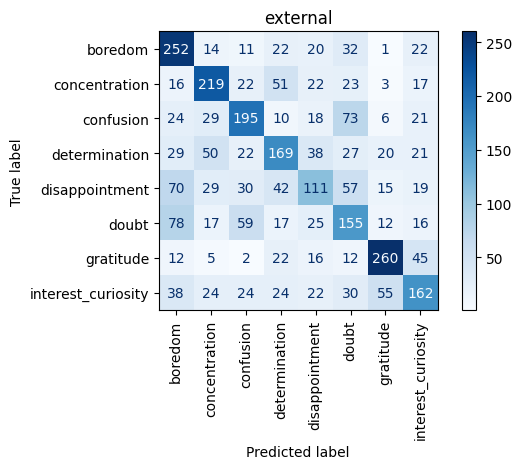

In [10]:
# Evaluate the model on the training data
y_pred = n_fold_cross_validation(best_params, X_train, y_train)
get_metrics(y_train, y_pred, condition="external")

In [11]:
# train the model
clf = SVC(**best_params)
clf.fit(X_train, y_train)

clf_proba = SVC(**best_params, probability=True)
clf_proba.fit(X_train, y_train)

SVC(C=5, class_weight='balanced', gamma=0.01, probability=True)


Evaluating for condition: furhat
(64, 186)
(64,)
              precision    recall  f1-score   support

           1       0.14      0.12      0.13         8
           2       0.22      0.25      0.24         8
           3       0.24      0.62      0.34         8
           7       0.00      0.00      0.00         8
          26       0.20      0.12      0.15         8
          27       0.33      0.12      0.18         8
          29       0.00      0.00      0.00         8
          37       0.09      0.12      0.11         8

    accuracy                           0.17        64
   macro avg       0.15      0.17      0.14        64
weighted avg       0.15      0.17      0.14        64

labels ['boredom' 'concentration' 'confusion' 'determination' 'disappointment'
 'doubt' 'gratitude' 'interest_curiosity']


/home/tim/Work/recordix/reco-transfer-study/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tim/Work/recordix/reco-transfer-study/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tim/Work/recordix/reco-transfer-study/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

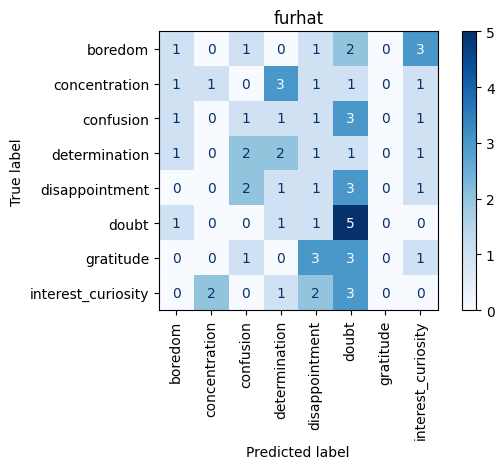


Evaluating for condition: metahuman
(64, 186)
(64,)
              precision    recall  f1-score   support

           1       0.11      0.12      0.12         8
           2       0.25      0.12      0.17         8
           3       0.18      0.50      0.27         8
           7       0.33      0.12      0.18         8
          26       0.00      0.00      0.00         8
          27       0.20      0.12      0.15         8
          29       0.40      0.25      0.31         8
          37       0.22      0.25      0.24         8

    accuracy                           0.19        64
   macro avg       0.21      0.19      0.18        64
weighted avg       0.21      0.19      0.18        64

labels ['boredom' 'concentration' 'confusion' 'determination' 'disappointment'
 'doubt' 'gratitude' 'interest_curiosity']


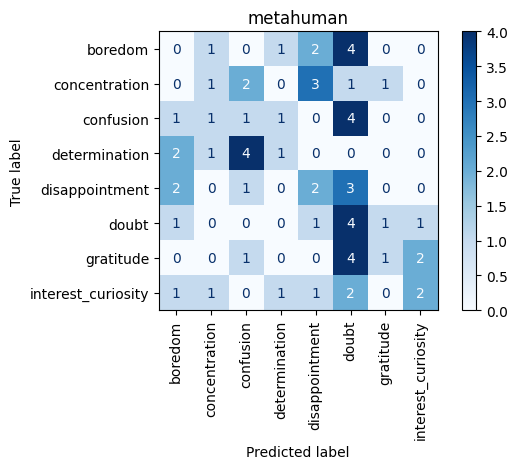


Evaluating for condition: original
(64, 186)
(64,)
              precision    recall  f1-score   support

           1       0.33      0.38      0.35         8
           2       0.60      0.38      0.46         8
           3       0.30      0.75      0.43         8
           7       0.75      0.38      0.50         8
          26       0.56      0.62      0.59         8
          27       0.50      0.50      0.50         8
          29       0.33      0.25      0.29         8
          37       0.67      0.25      0.36         8

    accuracy                           0.44        64
   macro avg       0.50      0.44      0.44        64
weighted avg       0.50      0.44      0.44        64

labels ['boredom' 'concentration' 'confusion' 'determination' 'disappointment'
 'doubt' 'gratitude' 'interest_curiosity']


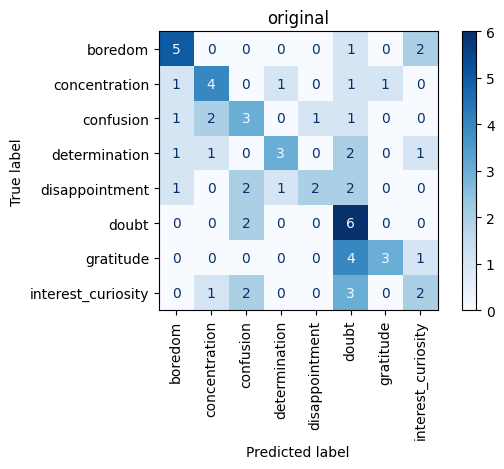

,condition,accuracy,f1_score,roc_auc_ovr
0,furhat,0.171875,0.144298,0.609375
1,metahuman,0.187500,0.178704,0.581752
2,original,0.437500,0.435080,0.736328


In [13]:
# Evaluate model on test data in different conditions
conditions = ["furhat", "metahuman", "original"]
all_scores = []
for c in conditions:
    print("\nEvaluating for condition:", c)

    df = df_conditions[df_conditions["condition"] == c]

    X_test = get_features_openface(df)

    y_test = df["emotion_id"].values

    print(X_test.shape)  # Number of rows and columns in the feature matrix
    print(y_test.shape)  # Number of rows in the target vector


    # Normalize the vectors
    video_ids = df["video_id"].values
    X_test = functional_scale_by(X_test, video_ids, "standard")

    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred, average="macro")
    roc_auc_ovr = metrics.roc_auc_score(y_test, clf_proba.predict_proba(X_test), multi_class="ovr")

    get_metrics(y_test, y_pred, condition=c)

    scores = {"condition": c, "accuracy": acc, "f1_score": f1_score, "roc_auc_ovr": roc_auc_ovr}

    all_scores.append(scores)

df_scores = pd.DataFrame(all_scores)
df_scores